In [1]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates import RYGate

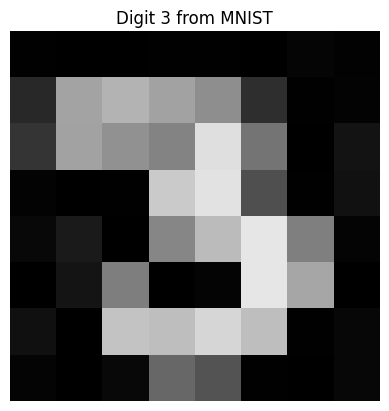

In [2]:
image = utils.plot_image('images/three_8by8.jpg', 'Digit 3 from MNIST')

In [3]:
def equal_superposition(circ: qiskit.QuantumCircuit, targets: int):
    for idx in range(targets): 
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])

    # Example
    # 0000 -> 0001
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, target: int, intensity: float):
    # Making the C^nRY manually improves visualization
    cry = RYGate(2 * intensity).control(len(control))
    aux = np.append(control, target).tolist()
    circ.append(cry, aux)
    #circ.mcry(theta = intensity,
    #          q_controls = control,
    #          q_target = target)

In [4]:
def construct_frqi(circ: qiskit.QuantumCircuit, control: list, 
                   target: qiskit.QuantumRegister, image: np.array):
    
    num_qubits = circ.num_qubits
    equal_superposition(circ, num_qubits - 1)
    
    for idx, angle in enumerate(image):
        # We make a binary string representation of `idx``
        #   of length `num_qubits - 1` (we only operate on coordinate qubits).
        state = '{0:0{1}b}'.format(idx-1, num_qubits -1) 
        next_state = '{0:0{1}b}'.format(idx, num_qubits - 1)
        
        if idx > 0:
            iterate(circ, state, next_state)
        
        pixel_encoding(circ, control, target, angle)
        circ.barrier()
    
    to_measure = [*range(num_qubits)]
    circ.measure(to_measure, to_measure)

In [5]:
flat_ang_rep = utils.get_angle_representation(image,
                                                min_val=0,
                                                max_val=255)

n = int(log(image.shape[0], 2))

# FRQI requires 2n + 1 qubits.
qRegCord = qiskit.QuantumRegister(2 * n, 'cord') 
qRegColor = qiskit.QuantumRegister(1, 'color') 
cReg = qiskit.ClassicalRegister(qRegCord.size+qRegColor.size, 'bits')

In [6]:
frqi_circ = qiskit.QuantumCircuit(qRegCord, qRegColor, cReg)
construct_frqi(frqi_circ, list(qRegCord), qRegColor[0], flat_ang_rep)

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


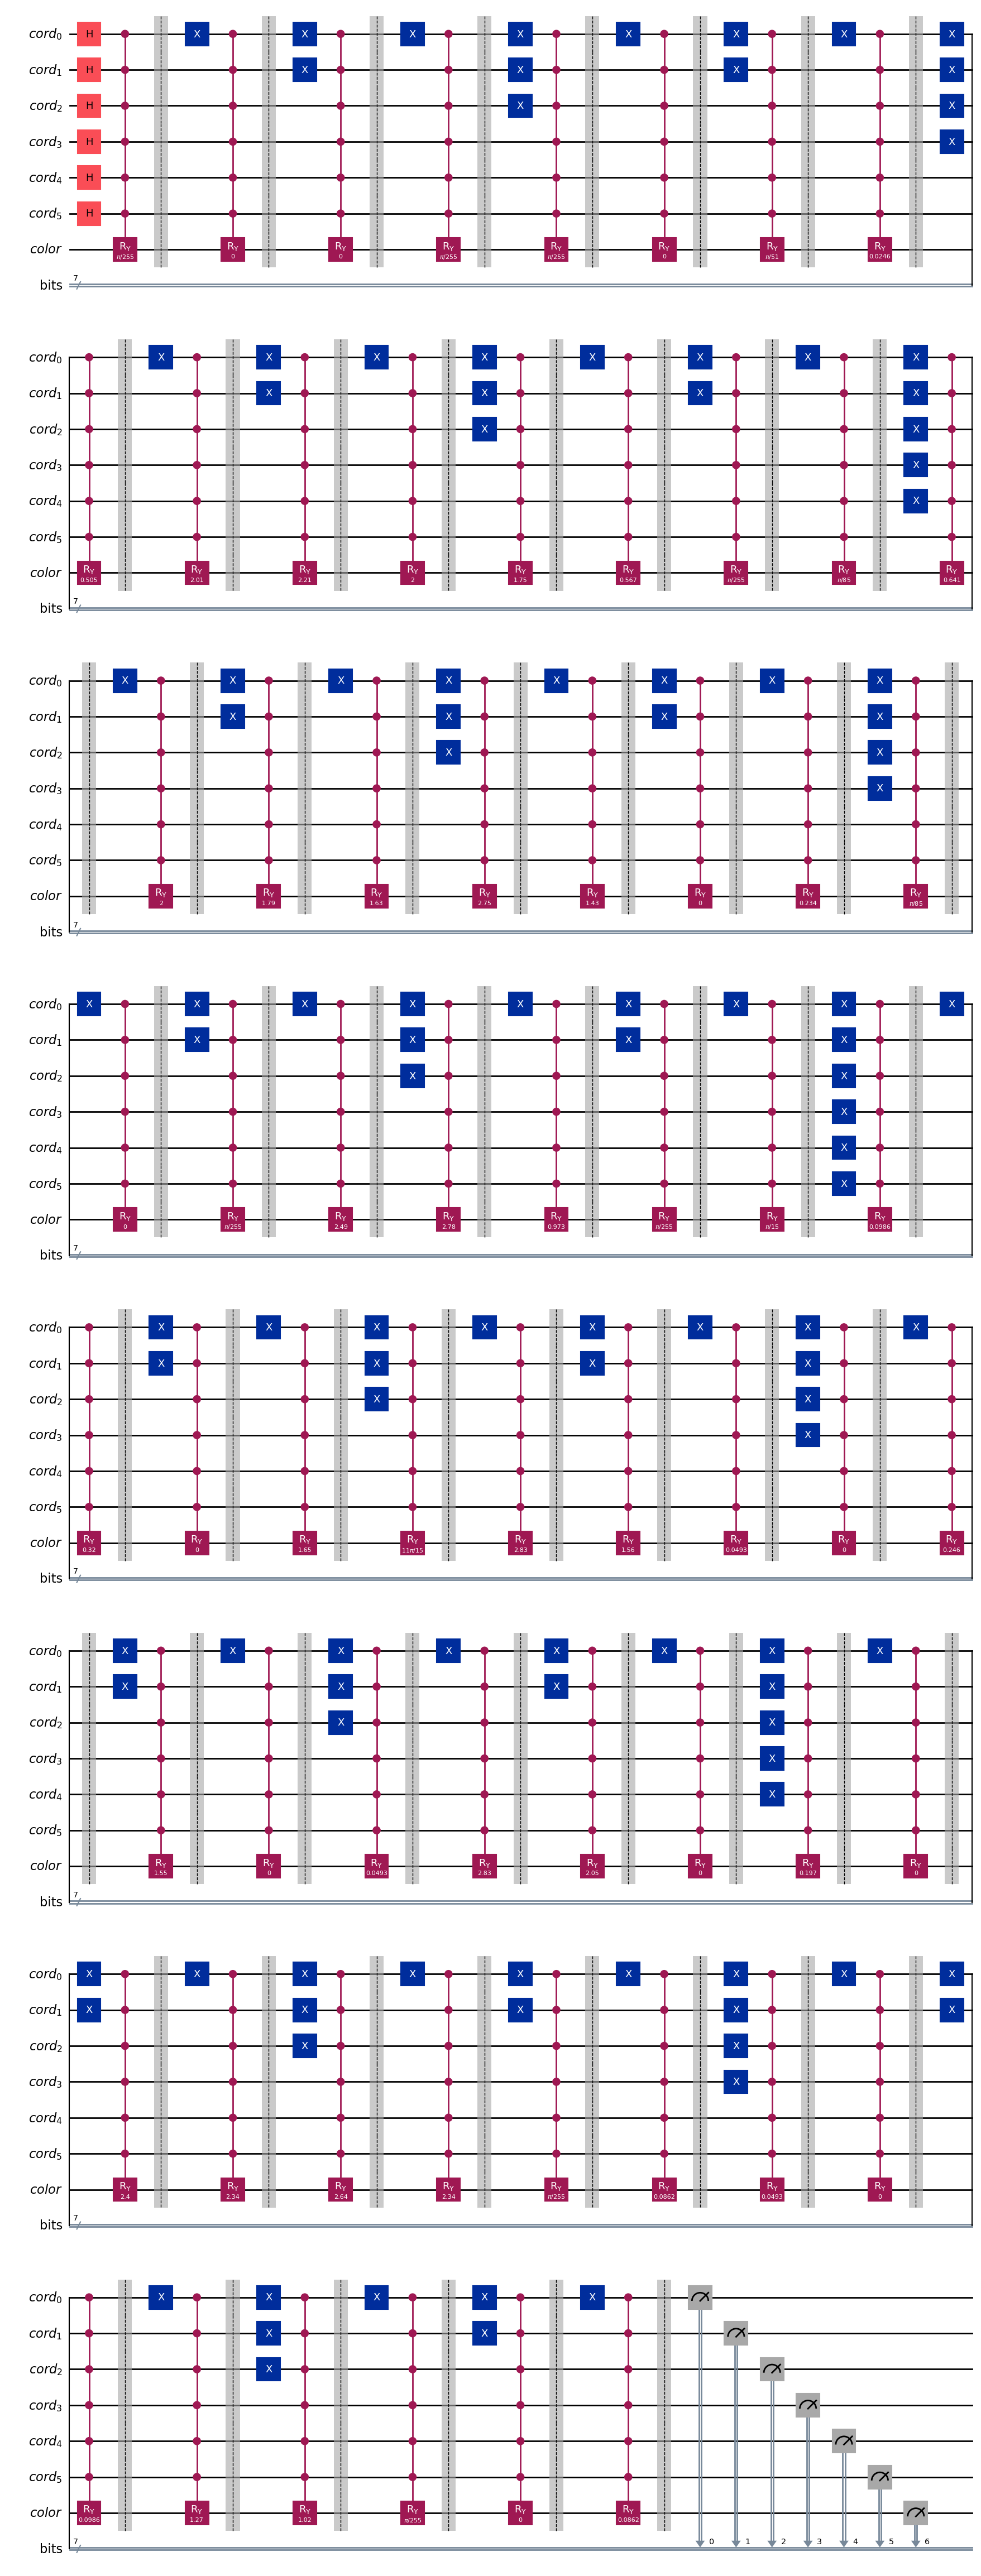

In [7]:
frqi_circ.draw(output='mpl')

In [8]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(frqi_circ, simulator)
shots = 10000
result = simulator.run(circuit, shots=shots).result()

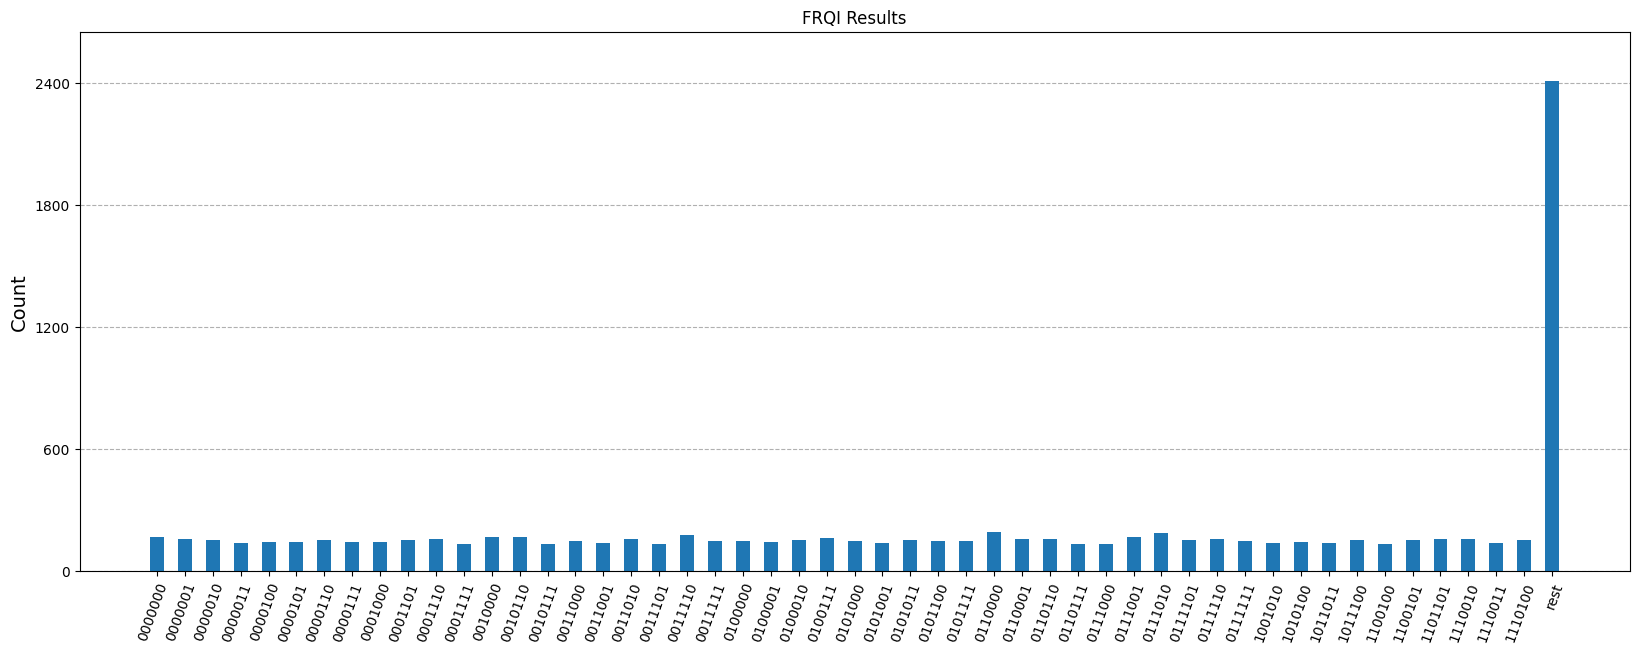

In [9]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="FRQI Results", bar_labels=False, number_to_keep=50)

In [10]:
n_pixels = len(flat_ang_rep)
retrieve_image = np.zeros(n_pixels)
num_qubits = frqi_circ.num_qubits

for idx in range(n_pixels):
  try:
    s = '{0:0{1}b}'.format(idx-1, num_qubits-1) 
    new_s = '1' + s
    
    retrieve_image[idx] = np.sqrt(counts[new_s]/shots)
  except KeyError:
    retrieve_image[idx] = 0.0

# I don't know why the eight is required
retrieve_image = np.interp(retrieve_image, (0, np.pi/2), (0, 8* 255)).astype(int)
#retrieve_image *=  8.0*255.0
#retrieve_image = retrieve_image.astype('int')
retrieve_image = retrieve_image.reshape(image.shape)

print(retrieve_image)
print()
print(image)

[[  0   0   0   0   0   0   0   0]
 [  0  43 134 152 140 120  46   0]
 [  0  50 124 121 117 154 110   0]
 [ 22   0   0   0 152 160  71   0]
 [  0   0  31   0 124 150 161 111]
 [  0   0  22 120   0   0 163 137]
 [  0  12   0 163 153 161 136   0]
 [  0   0   0  12  99  81   0   0]]

[[  1   0   0   1   1   0   5   2]
 [ 41 163 179 162 142  46   1   3]
 [ 52 162 145 132 223 116   0  19]
 [  3   0   1 202 226  79   1  17]
 [  8  26   0 134 187 230 127   4]
 [  0  20 126   0   4 230 166   0]
 [ 16   0 195 190 214 190   1   7]
 [  4   0   8 103  83   1   0   7]]


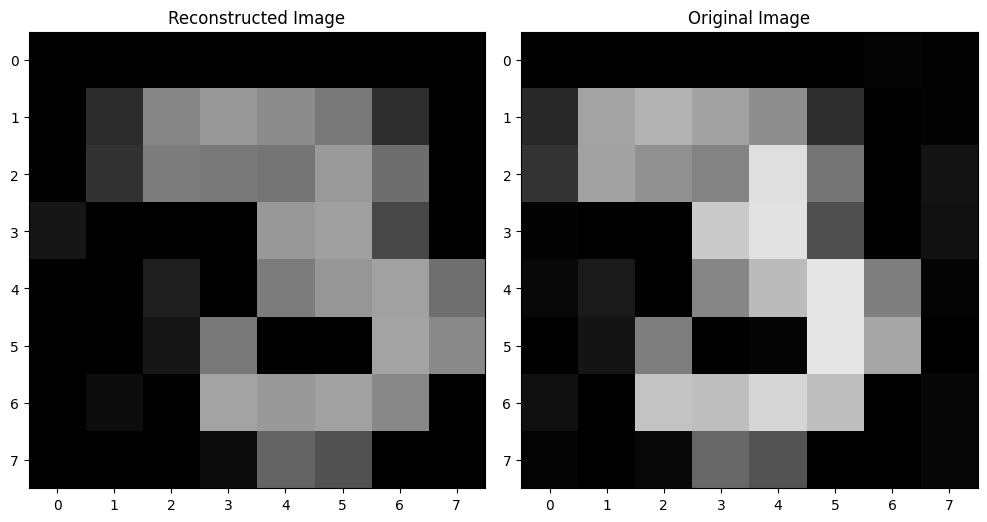

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(retrieve_image , cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()